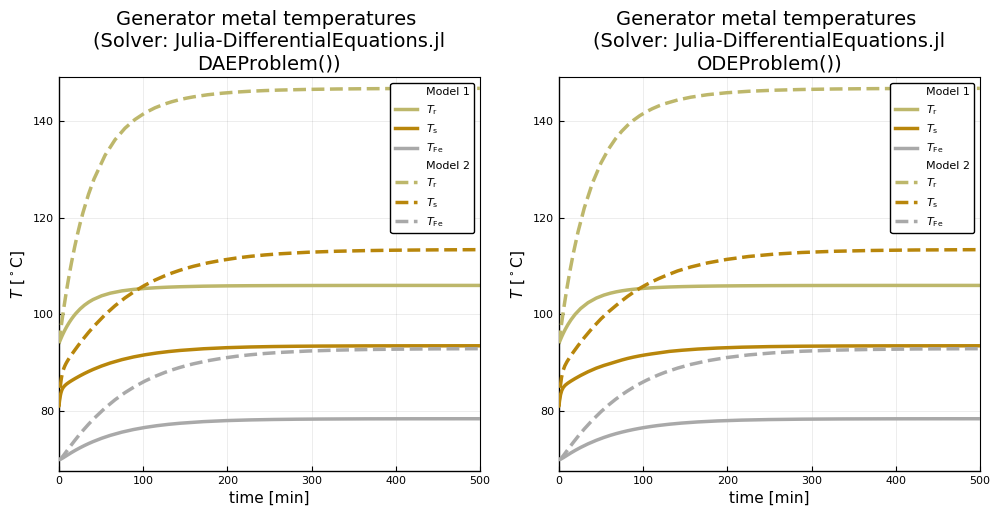

Plot{Plots.PyPlotBackend() n=16}

In [37]:
#Comparision of DAE 
#    for Model1 and Model2-CounterCurrentAnalytical
#    using Julia DifferentialEquation.jl (DAEProblem)
# Filename: Comparision-DAE-ODE-Model1-Model2CounterCurrentAnalytical-metal-temperature.ipynb
# Author:  Madhusudhan Pandey, USN-MSc. Electrical Power Engineering
# Date: March 15, 2019
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter3/";

# Loading necessary packages
using DifferentialEquations
using Sundials
using Plots; pyplot()
using Plots.PlotMeasures
using LaTeXStrings
# Plotting
# Linewidths and styles
LW1 = 2.5
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
# DAE solver using Julia DifferentialEquation.jl--DAEProblem
#Specifying Parameters
pa = 1.01e5 # " Atmospheric pressure , Pa "
#
chpa = 1.15 # " Specific heat capacity air , kJ.kg -1. K -1 # " 
chpw = 4.2 # " Specific heat capacity water , kJ.kg -1. K -1 # " 
chpCu = 0.385 # " Specific heat capacity copper , kJ.kg -1. K -1 # " 
chpFe = 0.465 # " Specific heat capacity iron , kJ.kg -1. K -1 # " 
#
mr = 9260. # " Mass of copper in rotor , kg # " 
ms = 6827. # " Mass of copper in stator , kg # " 
mFe = 71200. # " Mass of iron in stator , kg # " 
#
VhCu = 0.112e-3 # " Specific volume of copper , m3 / kg # " 
VhFe = 0.127e-3 # " Specific volume of iron , m3 / kg # " 
#
Vr = mr*VhCu # " Rotor copper volume , m3 # " 
Vs = ms*VhCu # " Stator copper volume , m3 # " 
VFe = mFe*VhFe # " Stator iron volume , m3 # " 
#
UAr2d = 2.7 # " Heat transfer , rotor copper to air gap , kW / K # " 
UAs2Fe = 20. # " Heat transfer , stator copper to stator iron , kW /K" 
UAFe2a = 14.3 # " Heat transfer , rotor iron to hot air , kW / K # " 
hAax = 55.6 # " Heat transfer , air side heat exchanger , kW / K # " 
hAwx = 222. # " Heat transfer , air side heat exchanger , kW / K # " 
UAx = 1/(1/ hAax +1/ hAwx ) # " Heat transfer , heat exchanger , kW / K "
#Up=0.88 # "Product of overall heat transfer and perimeter"
#
Hha_o = 0. # " Enthalpy of formation air , kJ / kg " 
HhCu_o = 0. # " Enthalpy of formation copper , kJ / kg # " 
HhFe_o = 0. # " Enthalpy of formation iron , kJ / kg # " 
#
Ta_o = 25. # " Standard state temperature air , C # " 
TCu_o = 25. # " Standard state temperature copper , C # " 
TFe_o = 25. # " Standard state temperature iron , C # " 
#
Rr = 0.16e-3 # " Ohmic resistance , rotor copper , kOhm, at 25 C # " 
Rs = 3.5e-6 # " Ohmic resistance , stator copper , kOhm, at 25 C"
alphaCu = 0.00404 # " Temperature coefficient of resistance for copper"
#
#tuples of parameters
parameters = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu];

# Model-1CounterCurrentAnalytical
function model1_counter_current_analytical(err,dxdt,x,par,t)
    #
    # Naming derivatives of differential variables
    dUrdt = dxdt[1]
    dUsdt = dxdt[2]
    dUFedt = dxdt[3]
    # Naming differential variables
    Ur = x[1]
    Us = x[2]
    UFe = x[3]
    # Naming algebraic variables
    Qdrs= x[4] # " Heat flow source in rotor copper , kW "
    Qdss = x[5] # " Heat flow source in stator copper , kW "
    Qdfs = x[6] # " Heat flow source due to friction loss , kW "
    Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
    Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
    QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
    #
    Hr = x[10] # " Enthalpy of rotor copper , kJ "
    Hs = x[11] # " Enthalpy of stator copper , kJ "
    HFe = x[12] # " Enthalpy of stator iron , kJ " 
    Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
    Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
    HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
    #
    Hdac = x[16] # " Convective enthalpy of cold air , kW "
    Hdad = x[17] # " Convective enthalpy of air gap air , kW "
    Hdah = x[18] # " Convective enthalpy of hot air , kW " 
    Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
    Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
    Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
    #
    Twh = x[22] # " Hot water temperature , C " 
    Tac = x[23] # " Cold air temperature , C "
    Tad = x[24] # " Air gap air temperature , C "
    Tah = x[25] # " Hot air temperature , C "
    #
    Tr = x[26] # " Temperature of rotor copper , C " 
    Ts = x[27] # " Temperature of stator copper , C "
    TFe = x[28] # " Temperature of stator iron , C "
    #
    NSta = x[29] # "Stanton number for air,-"
    NStw = x[30] # "Stanton number for water,-"
    NStd = x[31] # "Difference in Stanton numbers,-"
    Qdw2a = x[32] # "Heat flow across heat exchanger contact area,kW"
    
    pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu = par
    
    # Computing inputs
    Twc = u_Twc(t)
    Ifd = u_Ifd(t)
    It = u_It(t)
    QdFes = u_QdFes(t)
    Wdf = u_Wdf(t)
    mdw = u_mdw(t)
    mda = u_mda(t)
    #
    # Equations
    #----------
    # - Algebraic equations
    err[1] = Hdac - Hdad + Qdr2d + Qdfs
    err[2] = Hdad - Hdah + QdFe2a
    
    err[3] = -Qdrs + 1.1* Rr * Ifd ^2
    err[4] = -Qdss + 3.0* Rs * It ^2
    err[5] = -Qdr2d + UAr2d *( Tr - Tad )
    err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
    err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
    err[8] = -Qdfs + 0.8* Wdf
    
    err[9] = -Hhr + HhCu_o + chpCu *( Tr - TCu_o )
    err[10] = -Hhs + HhCu_o + chpCu *( Ts - TCu_o )
    err[11] = -HhFe + HhFe_o + chpFe *( TFe - TFe_o )
    err[12] = -Hhac + Hha_o + chpa *( Tac - Ta_o )
    err[13] = -Hhad + Hha_o + chpa *( Tad - Ta_o )
    err[14] = -Hhah + Hha_o + chpa *( Tah - Ta_o )
    
    err[15] = -Hr+ mr * Hhr 
    err[16] = -Hs + ms * Hhs 
    err[17] = -HFe + mFe * HhFe
    
    err[18] = -Ur + Hr - pa * Vr
    err[19] = -Us + Hs - pa * Vs
    err[20] = -UFe + HFe - pa * VFe
    #
    err[21] = -Hdac + mda * Hhac 
    err[22] = -Hdad + mda * Hhad
    err[23] = -Hdah + mda * Hhah
    #
    # - differential equations
    err[24] = -dUrdt + Qdrs - Qdr2d
    err[25] = -dUsdt + Qdss - Qds2Fe
    err[26] = -dUFedt + QdFes + Qds2Fe - QdFe2a
    # - analytical heat exchanger solution
    err[27] = -Twh + (NStw*(1-exp(-NStd))*Tah+NStd*exp(-NStd)*Twc)/(NStw-NSta*exp(-NStd))
    err[28] = -Tac + (NStd*Tah+NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
    err[29] = -Qdw2a + (exp(-NStd) -1) /( exp(-NStd) /(chpa*mda)-1/(chpw*mdw))*(Twc-Tah)
    err[30] = -NSta+UAx/chpa/mda
    err[31] = -NStw+UAx/chpw/mdw
    err[32] = -NStd+NStw-NSta
    #
    return err
end
# Model-2CounterCurrentAnalytical
function model2_counter_current_analytical(err,dxdt,x,par,t)
    #
    # Naming derivatives of differential variables
    dUrdt = dxdt[1]
    dUsdt = dxdt[2]
    dUFedt = dxdt[3]
    # Naming differential variables
    Ur = x[1]
    Us = x[2]
    UFe = x[3]
    # Naming algebraic variables
    Qdrs= x[4] # " Heat flow source in rotor copper , kW "
    Qdss = x[5] # " Heat flow source in stator copper , kW "
    Qdfs = x[6] # " Heat flow source due to friction loss , kW "
    Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
    Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
    QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
    #
    Hr = x[10] # " Enthalpy of rotor copper , kJ "
    Hs = x[11] # " Enthalpy of stator copper , kJ "
    HFe = x[12] # " Enthalpy of stator iron , kJ " 
    Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
    Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
    HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
    #
    Hdac = x[16] # " Convective enthalpy of cold air , kW "
    Hdad = x[17] # " Convective enthalpy of air gap air , kW "
    Hdah = x[18] # " Convective enthalpy of hot air , kW " 
    Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
    Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
    Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
    #
    Twh = x[22] # " Hot water temperature , C " 
    Tac = x[23] # " Cold air temperature , C "
    Tad = x[24] # " Air gap air temperature , C "
    Tah = x[25] # " Hot air temperature , C "
    #
    Tr = x[26] # " Temperature of rotor copper , C " 
    Ts = x[27] # " Temperature of stator copper , C "
    TFe = x[28] # " Temperature of stator iron , C "
    #
    NSta = x[29] # "Stanton number for air,-"
    NStw = x[30] # "Stanton number for water,-"
    NStd = x[31] # "Difference in Stanton numbers,-"
    Qdw2a = x[32] # "Heat flow across heat exchanger contact area,kW"
    Rrt = x[33]
    Rst = x[34]
    
    pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu = par
    
    # Computing inputs
    Twc = u_Twc(t)
    Ifd = u_Ifd(t)
    It = u_It(t)
    QdFes = u_QdFes(t)
    Wdf = u_Wdf(t)
    mdw = u_mdw(t)
    mda = u_mda(t)
    #
    # Equations
    #----------
    # - Algebraic equations
    err[1] = Hdac - Hdad + Qdr2d + Qdfs
    err[2] = Hdad - Hdah + QdFe2a
    
    err[3] = -Qdrs + 1.1* Rrt * Ifd ^2
    err[4] = -Qdss + 3.0* Rst * It ^2
    err[5] = -Qdr2d + UAr2d *( Tr - Tad )
    err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
    err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
    err[8] = -Qdfs + 0.8* Wdf
    
    err[9] = -Hhr + HhCu_o + chpCu *( Tr - TCu_o )
    err[10] = -Hhs + HhCu_o + chpCu *( Ts - TCu_o )
    err[11] = -HhFe + HhFe_o + chpFe *( TFe - TFe_o )
    err[12] = -Hhac + Hha_o + chpa *( Tac - Ta_o )
    err[13] = -Hhad + Hha_o + chpa *( Tad - Ta_o )
    err[14] = -Hhah + Hha_o + chpa *( Tah - Ta_o )
    
    err[15] = -Hr+ mr * Hhr 
    err[16] = -Hs + ms * Hhs 
    err[17] = -HFe + mFe * HhFe
    
    err[18] = -Ur + Hr - pa * Vr
    err[19] = -Us + Hs - pa * Vs
    err[20] = -UFe + HFe - pa * VFe
    #
    err[21] = -Hdac + mda * Hhac 
    err[22] = -Hdad + mda * Hhad
    err[23] = -Hdah + mda * Hhah
    #
    # - differential equations
    err[24] = -dUrdt + Qdrs - Qdr2d
    err[25] = -dUsdt + Qdss - Qds2Fe
    err[26] = -dUFedt + QdFes + Qds2Fe - QdFe2a
    # - analytical heat exchanger solution
    err[27] = -Twh + (NStw*(1-exp(-NStd))*Tah+NStd*exp(-NStd)*Twc)/(NStw-NSta*exp(-NStd))
    err[28] = -Tac + (NStd*Tah+NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
    err[29] = -Qdw2a + (exp(-NStd) -1) /( exp(-NStd) /(chpa*mda)-1/(chpw*mdw))*(Twc-Tah)
    err[30] = -NSta+UAx/chpa/mda
    err[31] = -NStw+UAx/chpw/mdw
    err[32] = -NStd+NStw-NSta
    # - Resistance equations residuals
    err[33] = -Rrt+Rr*(1+alphaCu*(Tr-TCu_o))
    err[34] = -Rst+Rs*(1+alphaCu*(Ts-TCu_o))
    #
    return err
end
# Defining inputs
#
function u_Twc(t)
    return 3.8 # deg C
end
#
function u_Ifd(t)
    return 1055. # A
end
#
function u_It(t)
    return 5360. # A
end
#
function u_QdFes(t)
    return 212. # kW
end
#
function u_Wdf(t)
    return 528. # kW
end
#
function u_mdw(t)
    return 53.9 # kg/s
end
#
function u_mda(t)
    return 49.2 # kg/s
end
#Initial state parameters
Tr0 = 94.  #Initial temperature of rotor copper temperature , C 
Ts0 = 81.  #Initial temperature of stator copper temperature , C
TFe0 = 70.  #Initial temperature of stator iron temperature , C 
Hhr0 = HhCu_o + chpCu *( Tr0 - TCu_o )  #Initial rotor specific enthalpy , kJ / kg  
Hhs0 = HhCu_o + chpCu *( Ts0 - TCu_o )  #Initial stator copper specific enthalpy , kJ / kg  
HhFe0 = HhFe_o + chpFe *( TFe0 - TFe_o )  #Initial stator iron specific enthalpy , kJ / kg  
Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ  
Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

#--- Model 1 Start DAE solver -----

# For Model1CounterCurrentAnalytical
# Approximated initial values for algebriac variables
x0 = zeros(32,1)
x0[1] = Ur0
x0[2] = Us0
x0[3] = UFe0
x0[4] = 1.1* Rr * u_Ifd(0)^2
x0[5] = 3.0* Rs * u_It(0)^2
x0[6] = 0.8* u_Wdf(0)
x0[7] = UAr2d * Tr0
x0[8] = UAs2Fe * Ts0
x0[9] = UAFe2a * TFe0
x0[10] = Hr0 
x0[11] = Hs0
x0[12] = HFe0
x0[13] = Hhr0
x0[14] = Hhs0
x0[15] = HhFe0
x0[16] = u_mda(0) * x0[20]
x0[17] = u_mda(0) * x0[21]
x0[18] = u_mda(0) * x0[22]
x0[19] = Hha_o 
x0[20] = Hha_o 
x0[21] = Hha_o 
x0[22] = u_Twc(0)
x0[23] = Ta_o
x0[24] = Ta_o
x0[25] = Ta_o
x0[26] = Tr0
x0[27] = Ts0
x0[28] = TFe0
x0[29] = UAx/chpa/u_mda(0)
x0[30] = UAx/chpw/u_mdw(0)
x0[31] = x0[30]-x0[29]
x0[32] = (exp(-x0[31]) -1) /( exp(-x0[31]) /(chpa*u_mda(0))-1/(chpw*u_mdw(0)))*(u_Twc(0)-x0[25])
# Initial derivatives
dxdt0 = zeros(32,1)
dxdt0[1]= x0[4]-x0[7]
dxdt0[2]= x0[5]-x0[8]
dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
# Simulating
# Specifying differential variables
diff_vars = fill(false,32)
diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
# Time span
tspan = (0.0,500*60.)
# Problem definition
prob1 = DAEProblem(model1_counter_current_analytical,dxdt0,x0,tspan,parameters,differential_vars=diff_vars)
sol1 = solve(prob1,IDA());
Tr1 = [sol1.u[i][26] for i in 1:length(sol1.u)]
Ts1 = [sol1.u[i][27] for i in 1:length(sol1.u)]
TFe1 = [sol1.u[i][28] for i in 1:length(sol1.u)]
t1 = [sol1.t[i] for i in 1:length(sol1.u)];
# Plotting
# Separating legend for Model1
plot(1,1,label="Model 1",lc=:white)
plot!(t1/60,Tr1,lc=:darkkhaki ,lw=LW1,ls=LS1,label=L"$T_\mathrm{r}$")
plot!(t1/60,Ts1,lc=:darkgoldenrod ,lw=LW1,label=L"$T_\mathrm{s}$")
plot!(t1/60,TFe1,lc=:darkgrey ,lw=LW1,label=L"$T_\mathrm{Fe}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]" )

#--- Model 2 Start DAE solver -----

# For Model2CounterCurrentAnalytical
#44 algebriac variables
x0 = zeros(34,1)
x0[1] = Ur0
x0[2] = Us0
x0[3] = UFe0
x0[4] = 1.1* Rr * u_Ifd(0)^2
x0[5] = 3.0* Rs * u_It(0)^2
x0[6] = 0.8* u_Wdf(0)
x0[7] = UAr2d * Tr0
x0[8] = UAs2Fe * Ts0
x0[9] = UAFe2a * TFe0
x0[10] = Hr0 
x0[11] = Hs0
x0[12] = HFe0
x0[13] = Hhr0
x0[14] = Hhs0
x0[15] = HhFe0
x0[16] = u_mda(0) * x0[20]
x0[17] = u_mda(0) * x0[21]
x0[18] = u_mda(0) * x0[22]
x0[19] = Hha_o 
x0[20] = Hha_o 
x0[21] = Hha_o 
x0[22] = u_Twc(0)
x0[23] = Ta_o
x0[24] = Ta_o
x0[25] = Ta_o
x0[26] = Tr0
x0[27] = Ts0
x0[28] = TFe0
x0[29] = UAx/chpa/u_mda(0)
x0[30] = UAx/chpw/u_mdw(0)
x0[31] = x0[30]-x0[29]
x0[32] = (exp(-x0[31]) -1) /( exp(-x0[31]) /(chpa*u_mda(0))-1/(chpw*u_mdw(0)))*(u_Twc(0)-x0[25])
# Specifying initial condition extra alg. variable, Rrt and Rst
x0[33] = Rr*(1-alphaCu*(Tr0-TCu_o))
x0[34] = Rs*(1-alphaCu*(Ts0-TCu_o))
dxdt0 = zeros(34,1)
dxdt0[1]= x0[4]-x0[7]
dxdt0[2]= x0[5]-x0[8]
dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
# Simulating
# Specifying differential variables
diff_vars = fill(false,34)
diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
# Time span
tspan = (0.0,500*60.)
# Problem definition
prob2 = DAEProblem(model2_counter_current_analytical,dxdt0,x0,tspan,parameters,differential_vars=diff_vars)
sol2 = solve(prob2,IDA());
Tr2 = [sol2.u[i][26] for i in 1:length(sol2.u)]
Ts2 = [sol2.u[i][27] for i in 1:length(sol2.u)]
TFe2 = [sol2.u[i][28] for i in 1:length(sol2.u)]
t2 = [sol2.t[i] for i in 1:length(sol2.u)];
# it contains !(bang) for plotting in same figure
# Separating legend for Model2
plot!(1,1,label="Model 2",lc=:white)
plot!(t2/60,Tr2,lc=:darkkhaki ,lw=LW1,ls=LS4,label=L"$T_\mathrm{r}$")
plot!(t2/60,Ts2,lc=:darkgoldenrod ,lw=LW1,ls=LS4,label=L"$T_\mathrm{s}$")
plot!(t2/60,TFe2,lc=:darkgrey ,lw=LW1,ls=LS4,label=L"$T_\mathrm{Fe}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]" )
plot!(title="Generator metal temperatures \n(Solver: Julia-DifferentialEquations.jl\nDAEProblem())",legend=:topright)
gen1_gen2_metal_temp_DAEJulia_solver=plot!(xlim=(0,500),reuse=false)

# ODE start

# ODE solver for Model1 and Model2 CounterCurrentAnalytical
# Model 1 function
function model1_counter_current_analytical_ode(x,u,t)
    # unpacking states
    Tr = x[1]
    Ts = x[2]
    TFe = x[3]
    # upacking inputs
    Twc = u[1]
    Ifd = u[2]
    It = u[3]
    QdFes = u[4]
    Wdf = u[5]
    mdw = u[6]
    mda = u[7]
    # parameters
    chpa = 1.15
    chpw = 4.2
    chpCu = 0.385
    chpFe = 0.465
    # Masses
    mr = 9260.
    ms = 6827.
    mFe = 71200.
    # Heat transfer coefficients
    UAr2d = 2.7
    UAs2Fe = 20.
    UAFe2a = 14.3
    hAax = 55.6
    hAwx = 222.
    UAx = 1/(1/hAax+1/hAwx)
    # Resistances
    Rr = 0.16e-3
    Rs = 3.5e-6
    # Heat rate from friction
    Qdfs = 0.8*Wdf
    # Stanton numbers
    NSta = UAx/chpa/mda
    NStw = UAx/chpw/mdw
    NStd = NStw - NSta
    # Matrices
    M1 = diagm(0=>[mr*chpCu , ms*chpCu , mFe*chpFe])
    M2 = [-UAr2d 0. 0.; 0. -UAs2Fe UAs2Fe; 0. UAs2Fe -UAs2Fe-UAFe2a]
    M3 = [0. UAr2d 0.; 0. 0. 0.; 0. 0. UAFe2a]
    #
    N1 = [-mda*chpa mda*chpa+UAr2d 0.; 0. -mda*chpa mda*chpa+UAFe2a; NStw-NSta*exp(-NStd) 0. -NStd]
    N2 = [UAr2d 0. 0.; 0. 0. UAFe2a; 0. 0. 0.]
    #
    v = [1.1*Rr*Ifd^2, 3*Rs*It^2, QdFes]
    w = [Qdfs, 0., NSta*(1-exp(-NStd))*Twc]
    z = N1\(N2*x + w)
    dxdt = M1\(M2*x+M3*z + v)
    return dxdt
end
# Model 2 Function
function model2_counter_current_analytical_ode(x,u,t)
    # unpacking states
    Tr = x[1]
    Ts = x[2]
    TFe = x[3]
    # upacking inputs
    Twc = u[1]
    Ifd = u[2]
    It = u[3]
    QdFes = u[4]
    Wdf = u[5]
    mdw = u[6]
    mda = u[7]
    # parameters
    chpa = 1.15
    chpw = 4.2
    chpCu = 0.385
    chpFe = 0.465
    alphaCu = 0.00404
    TCu_o = 25 
    # Masses
    mr = 9260.
    ms = 6827.
    mFe = 71200.
    # Heat transfer coefficients
    UAr2d = 2.7
    UAs2Fe = 20.
    UAFe2a = 14.3
    hAax = 55.6
    hAwx = 222.
    UAx = 1/(1/hAax+1/hAwx)
    # Resistances
    Rr = 0.16e-3
    Rs = 3.5e-6
    # Heat rate from friction
    Qdfs = 0.8*Wdf
    # Stanton numbers
    NSta = UAx/chpa/mda
    NStw = UAx/chpw/mdw
    NStd = NStw - NSta
    # Matrices
    M1 = diagm(0=>[mr*chpCu , ms*chpCu , mFe*chpFe])
    M2 = [-UAr2d+1.1*Rr*Ifd^2*alphaCu 0. 0.; 0. -UAs2Fe+3*Rs*It^2*alphaCu UAs2Fe; 0. UAs2Fe -UAs2Fe-UAFe2a]
    M3 = [0. UAr2d 0.; 0. 0. 0.; 0. 0. UAFe2a]
    #
    N1 = [-mda*chpa mda*chpa+UAr2d 0.; 0. -mda*chpa mda*chpa+UAFe2a; NStw-NSta*exp(-NStd) 0. -NStd]
    N2 = [UAr2d 0. 0.; 0. 0. UAFe2a; 0. 0. 0.]
    #
    v = [1.1*Rr*Ifd^2*(1-alphaCu*TCu_o), 3*Rs*It^2*(1-alphaCu*TCu_o), QdFes]
    w = [Qdfs, 0., NSta*(1-exp(-NStd))*Twc]

    z = N1\(N2*x + w)
    dxdt = M1\(M2*x+M3*z + v)
    return dxdt
end
# Inputs
u = [3.8,1055,5360,212,528,53.9,49.2]
# Initial states
x0 = [94., 81., 70.]
# Time span
tspan = (0., 500*60.)

# Set up problem-Model1
prob1 = ODEProblem(model1_counter_current_analytical_ode,x0,tspan,u)
# Solving model
sol1 = solve(prob1);

# Set up problem-Model2
prob2 = ODEProblem(model2_counter_current_analytical_ode,x0,tspan,u)
# Solving model
sol2 = solve(prob2);
# Plotting
# Separating legend for Model1
plot(1,1,label="Model 1",lc=:white)
plot!(sol1.t/60,sol1[1,:],lc=:darkkhaki ,lw=LW1,label=L"$T_\mathrm{r}$");
plot!(sol1.t/60,sol1[2,:],lc=:darkgoldenrod ,lw=LW1,label=L"$T_\mathrm{s}$");
plot!(sol1.t/60,sol1[3,:],lc=:darkgrey ,lw=LW1,label=L"$T_\mathrm{Fe}$");
# Separating legend for Model2
plot!(1,1,label="Model 2",lc=:white)
plot!(sol2.t/60,sol2[1,:],lc=:darkkhaki ,ls=LS4,lw=LW1,label=L"$T_\mathrm{r}$");
plot!(sol2.t/60,sol2[2,:],lc=:darkgoldenrod ,ls=LS4,lw=LW1,label=L"$T_\mathrm{s}$");
plot!(sol2.t/60,sol2[3,:],lc=:darkgrey ,ls=LS4,lw=LW1,label=L"$T_\mathrm{Fe}$");
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]" );
plot!(title="Generator metal temperatures \n(Solver: Julia-DifferentialEquations.jl\nODEProblem())",legend=:topright)
gen1_gen2_metal_temp_ODEJulia_solver=plot!(xlim=(0,500),reuse=false)

# Ploting DAE and ODE for Model1 and Model2 Using Julia
print(plot(gen1_gen2_metal_temp_DAEJulia_solver,gen1_gen2_metal_temp_ODEJulia_solver,
        layout=grid(1,2),size = (1000, 500), 
    framestyle = :box,right_margin=5mm))
figfile="DAE_ODE_model1_model2_analytical_Cnt_Cu_metal_temp_plot.svg"
savefig(figpath*figfile)
